In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from numpy import genfromtxt
from keras import regularizers
from keras.models import Sequential, Model
from keras.layers import Dense, Conv1D, Flatten, concatenate, Input, AveragePooling1D, MaxPooling1D, Dropout
from keras import optimizers

In [19]:
def readData():
    print("Reading Data..")
    data = genfromtxt('shuffledSet_w50_s10.txt')   #(total points of all examples) x (num. of logs (including logs to be predicted)).
    headers = pd.read_fwf("Headers.txt") #make sure there's no space in labels i.e BitSize is one label
    print('Data loading finished!')
    return data, headers

In [20]:
def processData(data, trainSize, devSize, testSize, numtotalLogs, numSamples ,ylogCol, xlogCol):
    print("Data processing..")
    dataReshape = data.reshape(data.shape[0]//numSamples,numSamples,numtotalLogs)
    y = dataReshape[:,:, ylogCol] 
    x = dataReshape[:,:, xlogCol]
    #yreshape = y.reshape(y.shape[0],numSamples*len(ylogCol))
    #xreshape = x.reshape(x.shape[0],numSamples*len(xlogCol))
    train_x = x[0:trainSize,:]
    train_y = y[0:trainSize,:]
    dev_x = x[trainSize:trainSize + devSize, :]
    dev_y = y[trainSize:trainSize + devSize, :]
    test_x = x[trainSize + devSize:trainSize + devSize + testSize, :]
    test_y = y[trainSize + devSize:trainSize + devSize + testSize, :]
    print('train_x shape: ', train_x.shape)
    print('train_y shape: ', train_y.shape)
    print('dev_x shape: ', dev_x.shape)
    print('dev_y shape: ', dev_y.shape)
    print('test_x shape: ', test_x.shape)
    print('test_y shape: ', test_y.shape)
    return train_x, train_y, dev_x, dev_y, test_x, test_y, dataReshape

In [21]:
#make random example
def viewOneExample(dataTensor, headers, xlogCol, ylogCol):
    logCol = []
    logCol.extend(xlogCol + ylogCol)
    #plot train_x and train_y as a function of depth
    fig, win = plt.subplots(1,len(logCol),sharey = True)
    strlist = list(headers)
    strlist = [strlist[j] for j in logCol]
    plt.ylabel('Depth') #not proper
    plt.gca().invert_yaxis()
    fig.suptitle('Training and Prediction Vs. Depth', y = 1.05) 
    fig.subplots_adjust(hspace = 1)
    fig.set_figheight(5)
    fig.set_figwidth(10)
    for i in range(len(logCol)):
        win[i].set_xlabel(strlist[i])
        win[i].plot(dataTensor[0,:,logCol[i]],dataTensor[0,:,0], Linewidth=2)
    plt.tight_layout()

In [32]:
def plotPred(x, y):
    #include header labels
    #include test
    #change back units
    #plot correct depth
    randInt = np.random.randint(0, x.shape[0],4)
    subplotNum = 4
    depth = np.array(list(range(1, 51)))
    fig, win = plt.subplots(1,subplotNum,sharey = True)
    plt.ylabel('Depth') #not proper
    plt.gca().invert_yaxis()
    fig.suptitle('Prediction vs. Depth', y = 0.95) 
    fig.subplots_adjust(hspace = 1)
    fig.set_figheight(5)
    fig.set_figwidth(10)
    out_y = modelGraph.predict(x)
    print('y_hat shape: ', out_y.shape)
    for i in range(subplotNum):
        win[i].plot(out_y[randInt[i],:],depth, Linewidth=2,color = 'r')
        win[i].plot(y[randInt[i],:],depth, Linewidth=2,color = 'b')
        win[i].legend(("prediction","original"), loc="upper right") #how to include in all plots


In [23]:
def inception1(train_x):
    conv3 = Conv1D(32, 3, activation='relu', padding='same'
                  , use_bias = True, kernel_initializer = keras.initializers.glorot_normal(seed=None))(train_x)
                  #, kernel_regularizer = regularizers.l2(0.05))(train_x)
    
    conv5 = Conv1D(32, 5, activation='relu', padding='same'
              , use_bias = True, kernel_initializer = keras.initializers.glorot_normal(seed=None))(train_x)
              #, kernel_regularizer = regularizers.l2(0.05))(train_x)
    
    conv7 = Conv1D(32, 7, activation='relu', padding='same'
          , use_bias = True, kernel_initializer = keras.initializers.glorot_normal(seed=None))(train_x)
          #, kernel_regularizer = regularizers.l2(0.05))(train_x)
    
    #conv15 = Conv1D(8, 15, activation='relu', padding='same'
    #  , use_bias = True, kernel_initializer = keras.initializers.glorot_normal(seed=None))(train_x)
      #, kernel_regularizer = regularizers.l2(0.05))(train_x)

    x = concatenate([conv3, conv5, conv7], axis = 2)#check the axis is right
    return x

In [24]:
def inception2(train_x):
    conv3 = Conv1D(64, 3, activation='relu', padding='same'
                  , use_bias = True, kernel_initializer = keras.initializers.glorot_normal(seed=None))(train_x)
                  #, kernel_regularizer = regularizers.l2(0.05))(train_x)
    
    conv5 = Conv1D(64, 5, activation='relu', padding='same'
              , use_bias = True, kernel_initializer = keras.initializers.glorot_normal(seed=None))(train_x)
              #, kernel_regularizer = regularizers.l2(0.05))(train_x)
    
    conv7 = Conv1D(64, 7, activation='relu', padding='same'
          , use_bias = True, kernel_initializer = keras.initializers.glorot_normal(seed=None))(train_x)
          #, kernel_regularizer = regularizers.l2(0.05))(train_x)

    x = concatenate([conv3, conv5, conv7], axis = 2)#check the axis is right
    return x

In [25]:
def plotLoss(history): #plotting the loss over epoch
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [57]:
def inception_model(train_x):
    inputs = Input(train_x.shape[1:]) #don't understand
    x = Conv1D(16, kernel_size = 3, strides = 1,activation='relu', padding = 'same'
                ,use_bias = True, kernel_initializer = keras.initializers.glorot_normal(seed=None))(inputs)
    x = Conv1D(32, kernel_size = 5, strides = 1,activation='relu', padding = 'same'
                ,use_bias = True, kernel_initializer = keras.initializers.glorot_normal(seed=None))(x)
    x = MaxPooling1D(3, strides=2, padding='same')(x) #average gave good results
    x = inception1(x)
    x = Conv1D(32, 1, activation='relu', padding='same'
                , use_bias = True, kernel_initializer = keras.initializers.glorot_normal(seed=None))(x)
    x = inception2(x)
    x = Conv1D(64, 1, activation='relu', padding='same'
                , use_bias = True, kernel_initializer = keras.initializers.glorot_normal(seed=None))(x)
    x = AveragePooling1D(7, strides=2, padding='same')(x) #average gave good results
    x = Flatten()(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    out_y = Dense(numSamples*len(ylogCol), activation='linear')(x)
     model = Model(input= inputs, output=out_y)
    model.compile(optimizer = 'adam', loss='mse')

    return model

In [27]:
#readData
#============================================ HEADERS ============================================
# Depth    ROP     WOB     RPM     Torque     BitSize     GR     RHOB     NPHI     DT     RD
# 0        1       2       3       4          5           6      7        8        9      10 
#=================================================================================================
#========================================== HEADERS MSE ========================================
# Depth    ROP     WOB     RPM     Torque     Flow_IN     MSE     GR     RHOB     NPHI
# 0        1       2       3       4          5           6       7        8      9       
#=================================================================================================
data, headers = readData()

Reading Data..
Data loading finished!


Data processing..
train_x shape:  (7000, 50, 3)
train_y shape:  (7000, 50, 1)
dev_x shape:  (0, 50, 3)
dev_y shape:  (0, 50, 1)
test_x shape:  (500, 50, 3)
test_y shape:  (500, 50, 1)


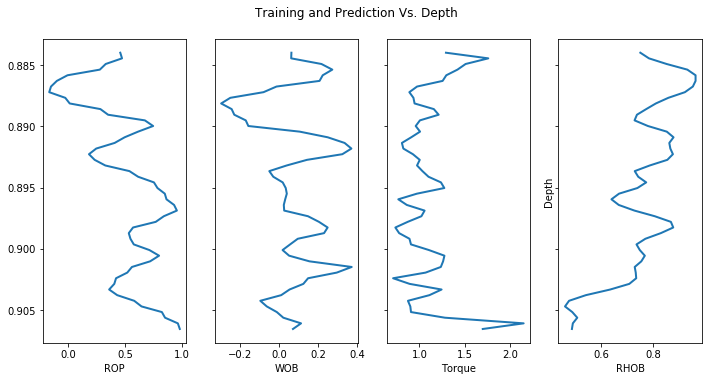

In [29]:
#processData
ylogCol = [7]; xlogCol = [1,2,4] #col starts from 0.
numtotalLogs = 11; numSamples = 50;
trainSize = 7000; devSize = 0; testSize = 500;
batch_size = 128
train_x, train_y, dev_x, dev_y, test_x, test_y, dataTensor = processData(data, trainSize, devSize, testSize, numtotalLogs, numSamples, ylogCol, xlogCol)
viewOneExample(dataTensor, headers, xlogCol, ylogCol)

In [58]:
#network input reshaping
train_y = train_y.reshape(train_y.shape[0],numSamples*len(ylogCol))
test_y = test_y.reshape(test_y.shape[0],numSamples*len(ylogCol))
#build model
modelGraph = inception_model(train_x)
modelGraph.summary()
history = modelGraph.fit(train_x, train_y, batch_size = batch_size, epochs=500, verbose=2, validation_data=(test_x, test_y))

C:\Users\kanfar\AppData\Local\Continuum\anaconda3\envs\Tensor\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 50, 3)        0                                            
__________________________________________________________________________________________________
conv1d_51 (Conv1D)              (None, 50, 16)       160         input_6[0][0]                    
__________________________________________________________________________________________________
conv1d_52 (Conv1D)              (None, 50, 32)       2592        conv1d_51[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_6 (MaxPooling1D)  (None, 25, 32)       0           conv1d_52[0][0]                  
__________________________________________________________________________________________________
conv1d_53 

Epoch 64/500
 - 3s - loss: 0.1188 - val_loss: 0.2052
Epoch 65/500
 - 3s - loss: 0.1300 - val_loss: 0.1781
Epoch 66/500
 - 3s - loss: 0.1145 - val_loss: 0.1762
Epoch 67/500
 - 3s - loss: 0.1060 - val_loss: 0.1739
Epoch 68/500
 - 3s - loss: 0.1098 - val_loss: 0.1809
Epoch 69/500
 - 3s - loss: 0.1024 - val_loss: 0.1720
Epoch 70/500
 - 3s - loss: 0.1023 - val_loss: 0.1671
Epoch 71/500
 - 3s - loss: 0.1037 - val_loss: 0.1672
Epoch 72/500
 - 3s - loss: 0.0987 - val_loss: 0.1651
Epoch 73/500
 - 3s - loss: 0.0977 - val_loss: 0.1726
Epoch 74/500
 - 3s - loss: 0.1014 - val_loss: 0.1634
Epoch 75/500
 - 3s - loss: 0.1014 - val_loss: 0.1651
Epoch 76/500
 - 3s - loss: 0.0968 - val_loss: 0.1638
Epoch 77/500
 - 3s - loss: 0.1001 - val_loss: 0.1723
Epoch 78/500
 - 3s - loss: 0.0969 - val_loss: 0.1602
Epoch 79/500
 - 3s - loss: 0.0931 - val_loss: 0.1626
Epoch 80/500
 - 3s - loss: 0.0906 - val_loss: 0.1603
Epoch 81/500
 - 3s - loss: 0.0889 - val_loss: 0.1620
Epoch 82/500
 - 3s - loss: 0.0922 - val_loss: 

Epoch 217/500
 - 3s - loss: 0.0540 - val_loss: 0.1373
Epoch 218/500
 - 3s - loss: 0.0557 - val_loss: 0.1426
Epoch 219/500
 - 3s - loss: 0.0607 - val_loss: 0.1418
Epoch 220/500
 - 3s - loss: 0.0540 - val_loss: 0.1393
Epoch 221/500
 - 3s - loss: 0.0520 - val_loss: 0.1341
Epoch 222/500
 - 3s - loss: 0.0506 - val_loss: 0.1435
Epoch 223/500
 - 3s - loss: 0.0500 - val_loss: 0.1325
Epoch 224/500
 - 3s - loss: 0.0499 - val_loss: 0.1350
Epoch 225/500
 - 3s - loss: 0.0620 - val_loss: 0.1663
Epoch 226/500
 - 3s - loss: 0.0918 - val_loss: 0.1928
Epoch 227/500
 - 3s - loss: 0.0705 - val_loss: 0.1439
Epoch 228/500
 - 3s - loss: 0.0660 - val_loss: 0.1450
Epoch 229/500
 - 3s - loss: 0.0593 - val_loss: 0.1303
Epoch 230/500
 - 3s - loss: 0.0519 - val_loss: 0.1328
Epoch 231/500
 - 3s - loss: 0.0496 - val_loss: 0.1339
Epoch 232/500
 - 3s - loss: 0.0492 - val_loss: 0.1306
Epoch 233/500
 - 3s - loss: 0.0495 - val_loss: 0.1351
Epoch 234/500
 - 2s - loss: 0.0492 - val_loss: 0.1319
Epoch 235/500
 - 2s - loss: 

Epoch 369/500
 - 2s - loss: 0.0403 - val_loss: 0.1233
Epoch 370/500
 - 3s - loss: 0.0404 - val_loss: 0.1265
Epoch 371/500
 - 3s - loss: 0.0404 - val_loss: 0.1250
Epoch 372/500
 - 2s - loss: 0.0404 - val_loss: 0.1240
Epoch 373/500
 - 2s - loss: 0.0401 - val_loss: 0.1262
Epoch 374/500
 - 2s - loss: 0.0405 - val_loss: 0.1237
Epoch 375/500
 - 2s - loss: 0.0414 - val_loss: 0.1268
Epoch 376/500
 - 3s - loss: 0.0404 - val_loss: 0.1222
Epoch 377/500
 - 3s - loss: 0.0401 - val_loss: 0.1336
Epoch 378/500
 - 2s - loss: 0.0410 - val_loss: 0.1269
Epoch 379/500
 - 2s - loss: 0.0406 - val_loss: 0.1257
Epoch 380/500
 - 2s - loss: 0.0398 - val_loss: 0.1246
Epoch 381/500
 - 2s - loss: 0.0404 - val_loss: 0.1273
Epoch 382/500
 - 3s - loss: 0.0403 - val_loss: 0.1255
Epoch 383/500
 - 3s - loss: 0.0412 - val_loss: 0.1255
Epoch 384/500
 - 2s - loss: 0.0404 - val_loss: 0.1258
Epoch 385/500
 - 3s - loss: 0.0404 - val_loss: 0.1230
Epoch 386/500
 - 2s - loss: 0.0409 - val_loss: 0.1283
Epoch 387/500
 - 2s - loss: 

y_hat shape:  (7000, 50)


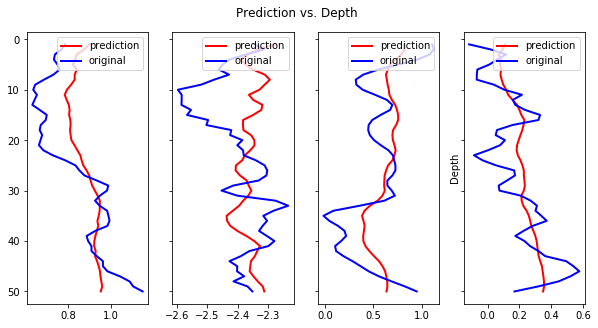

In [61]:
plotPred(train_x, train_y)

y_hat shape:  (500, 50)


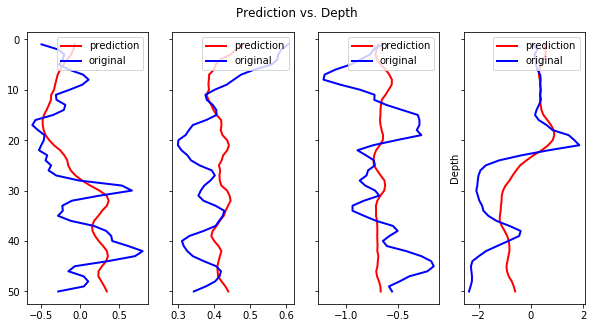

In [60]:
plotPred(test_x, test_y)

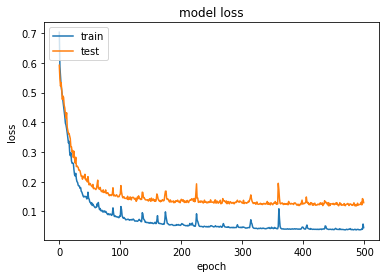

In [62]:
plotLoss(history)